In [1]:
import pandas as pd
import yfinance as yf
import datetime
from datetime import date, timedelta
today = date.today()

In [2]:
d1 = today.strftime("%Y-%m-%d")
end_date = d1
d2 = date.today() - timedelta(days=365)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2


In [8]:
data = yf.download('GOOG',
                      start=start_date,
                      end=end_date,
                      progress=False)
data["Date"] = data.index
data = data[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]
data.reset_index(drop=True, inplace=True)
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
246,2024-08-08,162.343994,165.500000,162.029999,163.839996,163.839996,15733600
247,2024-08-09,161.645004,165.520004,160.929993,165.389999,165.389999,13549200
248,2024-08-12,165.994995,166.699997,163.550003,163.949997,163.949997,12435000
249,2024-08-13,165.184998,166.539993,164.770004,165.929993,165.929993,12717600
250,2024-08-14,164.210007,164.960007,159.529999,162.029999,162.029999,22472600


In [4]:
data = data[["Date", "Close"]]
print(data.head())

        Date       Close
0 2023-08-16  129.110001
1 2023-08-17  130.460007
2 2023-08-18  128.110001
3 2023-08-21  128.929993
4 2023-08-22  129.690002


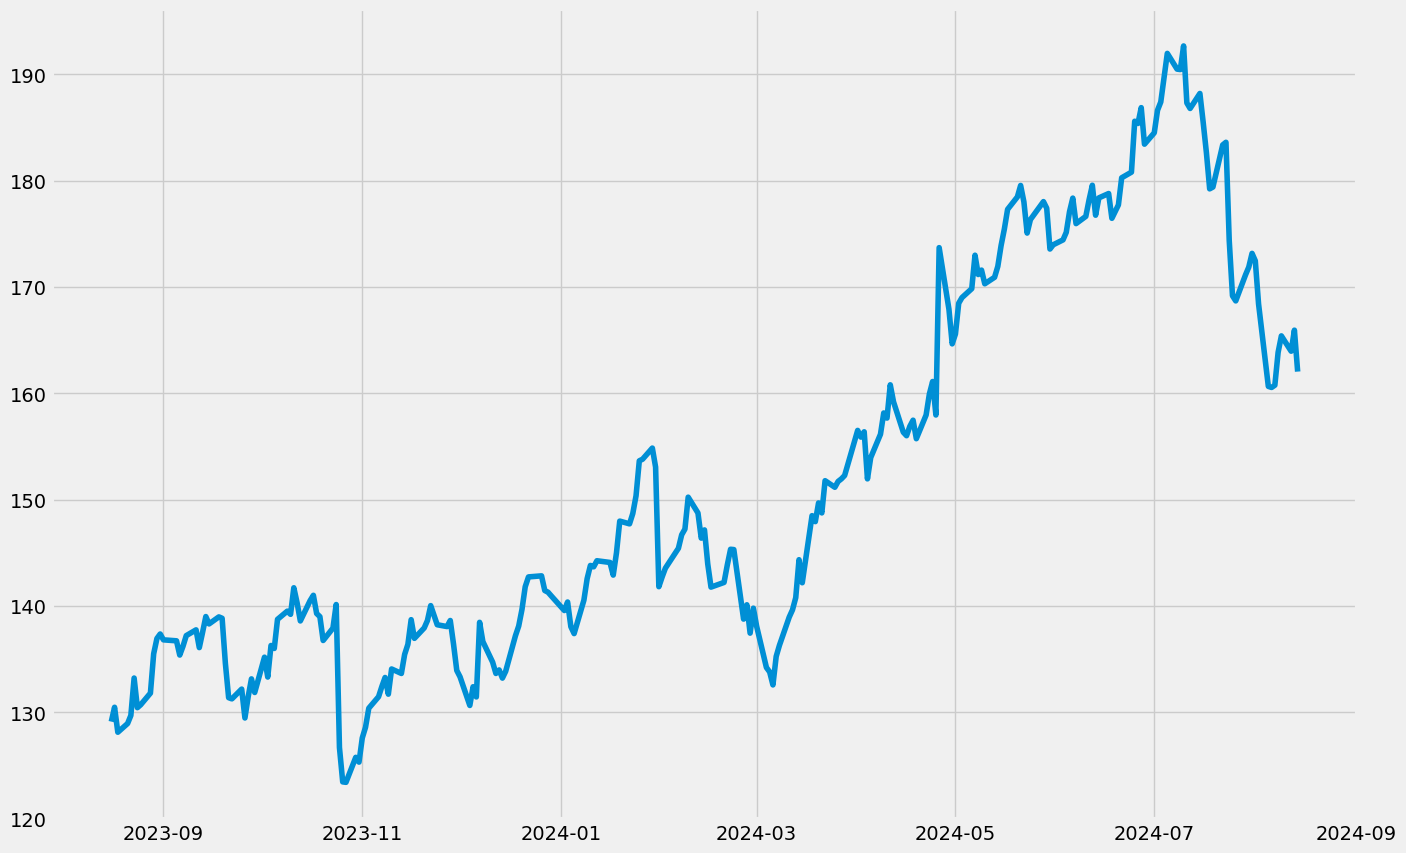

In [5]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 10))
plt.plot(data["Date"], data["Close"])

<Figure size 640x480 with 0 Axes>

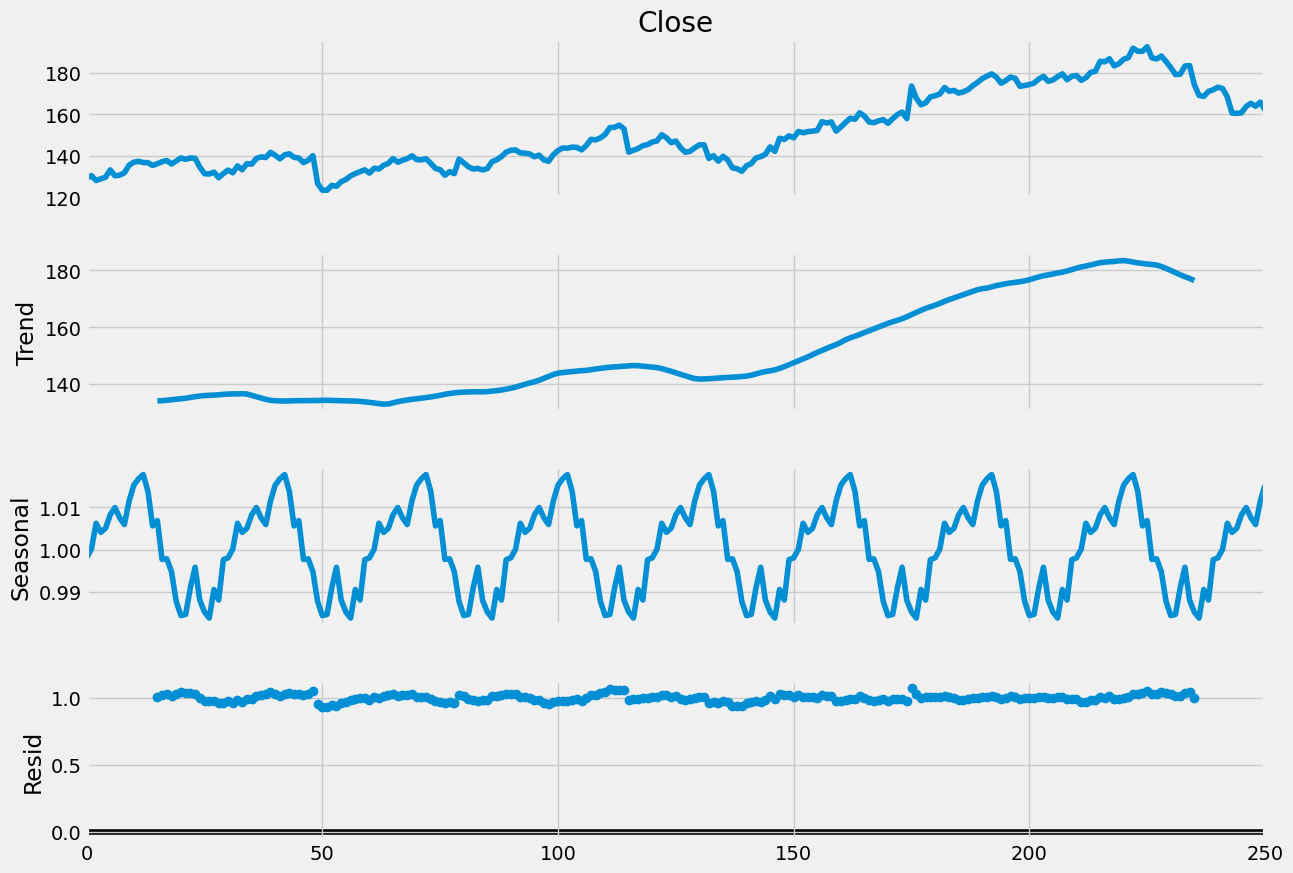

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data["Close"],
                            model='multiplicative', period = 30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(15, 10)

So our data is not stationary it is seasonal. We need to use the Seasonal ARIMA (SARIMA) model for Time Series Forecasting on this data. But before using the SARIMA model, we will use the ARIMA model. It will help you learn using both models.

To use ARIMA or SARIMA, we need to find the p, d, and q values. We can find the value of p by plotting the autocorrelation of the Close column and the value of q by plotting the partial autocorrelation plot. The value of d is either 0 or 1. If the data is stationary, we should use 0, and if the data is seasonal, we should use 1. As our data is seasonal, we should use 1 as the d value.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

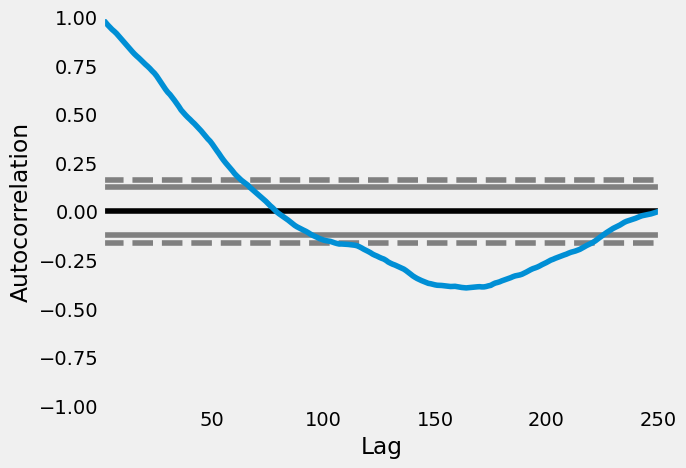

In [9]:
pd.plotting.autocorrelation_plot(data["Close"])

In the above autocorrelation plot, the curve is moving down after the 5th line of the first boundary. That is how to decide the p-value. Hence the value of p is 5. Now let’s find the value of q (moving average):

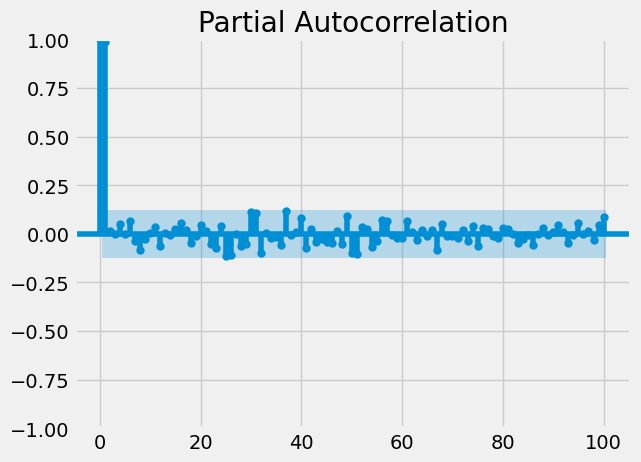

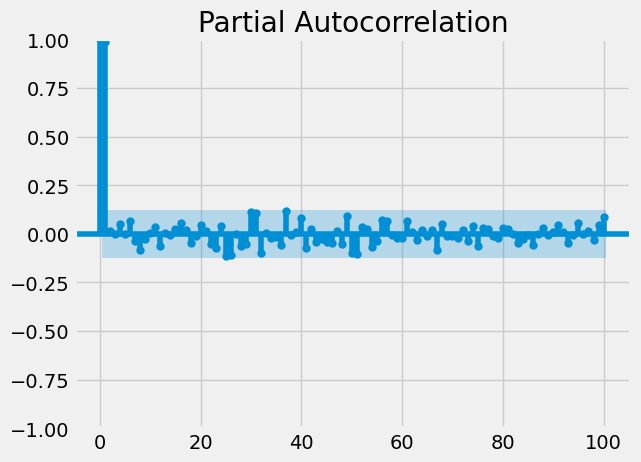

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data["Close"], lags = 100)

In the above partial autocorrelation plot, we can see that only two points are far away from all the points. That is how to decide the q value. Hence the value of q is 2. Now let’s build an ARIMA model:

In [11]:
p, d, q = 5, 1, 2
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(data["Close"], order=(p,d,q))
fitted = model.fit(disp=-1)
print(fitted.summary())

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


In [ ]:
predictions = fitted.predict()
print(predictions)

2     -2.108482
3     -0.789990
4     -3.688940
5     -0.777623
6     -2.472432
         ...   
247    2.866723
248    2.486679
249    7.659670
250    5.277199
251    8.960482
Length: 250, dtype: float64

The predicted values are wrong because the data is seasonal. ARIMA model will never perform well on seasonal time series data. So, here’s how to build a SARIMA model:

In [13]:
import statsmodels.api as sm
import warnings
model=sm.tsa.statespace.SARIMAX(data['Close'],
                                order=(p, d, q),
                                seasonal_order=(p, d, q, 12))
model=model.fit()
print(model.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  251
Model:             SARIMAX(5, 1, 2)x(5, 1, 2, 12)   Log Likelihood                -581.665
Date:                            Thu, 15 Aug 2024   AIC                           1193.330
Time:                                    05:15:51   BIC                           1245.414
Sample:                                         0   HQIC                          1214.321
                                            - 251                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2995      1.106     -0.271      0.787      -2.468       1.869
ar.L2         -0.6742      1.148   

In [ ]:
predictions = model.predict(len(data), len(data)+10)
print(predictions)

In [ ]:
data["Close"].plot(legend=True, label="Training Data", figsize=(15, 10))
predictions.plot(legend=True, label="Predictions")